In [1]:
import pandas as pd, numpy as np, plotly.express as px
from scipy.integrate import odeint
from numpy import linalg as LA
import datetime
import matplotlib.pyplot as plt
from pywaffle import Waffle
from IPython.display import clear_output

In [24]:
#Taxa reprodutiva padrão
def taxa_reprodutiva(N, be, b0, b1, b2, b3, p1, p2, g0, g1, g2, g3, a1, u, f):
    
    return N*((be/a1)+f*(b0/g0)+(1-f)*((b1/(p1+g1))+(p1/(p1+g1))*(b2/(p2+g2)+ (p2/(p2+g2))*(b3/(u+g3)))))

#Taxa reprodutiva com sazonalidade
def taxa_reprodutiva_seas(N, be, b0, b1, b2, b3, p1, p2, g0, g1, g2, g3, a1, u, f, SeasAmp, SeasPhase):

    Ro_now = N*((b1/(p1+g1))+(p1/(p1+g1))*(b2/(p2+g2)+ (p2/(p2+g2))*(b3/(u+g3))))*(1 + SeasAmp*np.cos(2*np.pi*(0-SeasPhase)/365))
    Ro_max = N*((b1/(p1+g1))+(p1/(p1+g1))*(b2/(p2+g2)+ (p2/(p2+g2))*(b3/(u+g3))))*(1 + SeasAmp)
    Ro_min = N*((b1/(p1+g1))+(p1/(p1+g1))*(b2/(p2+g2)+ (p2/(p2+g2))*(b3/(u+g3))))*(1 - SeasAmp)
    
    return Ro_now, Ro_max, Ro_min

#Cálculo dos parâmetros do modelo SEIR            
def params(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N):
    if PresymPeriod > 0:
        a1 = min(10^6,1/PresymPeriod) #Frequênca de surgimento do vírus
    else:
        a1 = 10^6
         
    if IncubPeriod > PresymPeriod:
        a0 = min(10^6, 1/(IncubPeriod - PresymPeriod)) #Frequência de incubação até possibilidade de transmissão
    else:
        a0 = 10^6
    f = FracAsym #Fração de assintomáticos
    
    g0 = 1/DurAsym #Taxa de recuperação dos assintomáticos
        
    if FracCritical==0:
        u=0
    else:
        u=(1/TimeICUDeath)*(CFR/FracCritical)
            
    g1 = (1/DurMildInf)*FracMild #Taxa de recuperação I1
    p1 = (1/DurMildInf) - g1 #Taxa de progreção I1

    g3 = (1/TimeICUDeath)-u #Taxa de recuperação I3
    
    p2 = (1/DurHosp)*(FracCritical/(FracCritical+FracSevere)) #Taxa de progressão I2
    g2 = (1/DurHosp) - p2 #Taxa de recuperação de I2

    ic=np.zeros(9) #Inicia vetor da população (cada índice para cada tipo de infectado, exposto, etc)
    ic[0]= N-i #População
    ic[1] = i #População exposta
        
    return a0, a1, u, g0, g1, g2, g3, p1, p2, f, ic

    
#Simulação com intevenção
def simulacao(TimeStart, TimeEnd, tmax, i, N, a0, a1, b0, be, b1, b2, b3, b0Int, beInt, b1Int, b2Int, b3Int, g0, g1, g2, g3, p1, p2 , u, names, f, AllowAsym, AllowPresym, SeasAmp, SeasPhase):
    if TimeEnd>TimeStart: #Se há intervenção
        if TimeStart > 0: #Se a intervenção começa após o dia 0
            #Simulação sem intervenção (antes do início da intervenção)
            ic = np.zeros(9) #Inicia vetor da população (cada índice para cada tipo de infectado, exposto, etc)
            ic[0] = N-i #População sucetível = tamanho da população
            ic[1] = i #População exposta
            tvec = np.arange(0,TimeStart,0.1) #A simulação sem intervenção termina em t = TimeStart
            sim_sem_int_1 = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
            ic = sim_sem_int_1[-1] #Salva a população atual
                
            #Criando DataFrame
            df_sim_com_int = pd.DataFrame(sim_sem_int_1, columns = names)
            df_sim_com_int['Tempo (dias)'] = tvec
            df_sim_com_int['Simulação'] = 'Com intervenção'
            
            #Simulação após o início da intervenção
            tvec=np.arange(TimeStart,TimeEnd,0.1)
            sim_com_int = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,beInt,b0Int,b1Int,b2Int,b3Int,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
            ic = sim_com_int[-1] #Salva população atual
            #Criando DataFrame
            df_aux = pd.DataFrame(sim_com_int, columns = names)
            df_aux['Tempo (dias)'] = tvec
            df_aux['Simulação'] = 'Com intervenção'
            #Append dataframe
            df_sim_com_int = df_sim_com_int.append(df_aux)
                
            if TimeEnd < tmax: #Se a intervenção termina antes do tempo final
                tvec = np.arange(TimeEnd,tmax,0.1) #A simulação sem intervenção termina em t = TimeStart
                #Simulação sem intervenção (após o fim da intervenção)
                sim_sem_int_2 = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
                #Criando dataframe
                df_aux = pd.DataFrame(sim_sem_int_2, columns = names)
                df_aux['Tempo (dias)'] = tvec
                df_aux['Simulação'] = 'Com intervenção'
                #Append dataframe
                df_sim_com_int = df_sim_com_int.append(df_aux)
                    
                    
        elif TimeStart == 0: #Se a intervenção começa no dia 0
            ic = np.zeros(9) #Inicia vetor da população (cada índice para cada tipo de infectado, exposto, etc)
            ic[0] = N - i #População sucetível = tamanho da população
            ic[1] = i
            tvec=np.arange(0,TimeEnd,0.1)
            sim_com_int = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,beInt,b0Int,b1Int,b2Int,b3Int,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
            ic = sim_com_int[-1]
            df_sim_com_int = pd.DataFrame(sim_com_int, columns = names)
            df_sim_com_int['Tempo (dias)'] = tvec
            df_sim_com_int['Simulação'] = 'Com intervenção'
            #sim = sim_com_int
            if TimeEnd < tmax: #Se a intervenção termina antes do tempo final
                tvec = np.arange(TimeEnd,tmax,0.1) #A simulação sem intervenção termina em t = TimeStart
                #Simulação sem intervenção (após o fim da intervenção)
                sim_sem_int_2 = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
                #Criando dataframe
                df_aux = pd.DataFrame(sim_sem_int_2, columns = names)
                df_aux['Tempo (dias)'] = tvec
                df_aux['Simulação'] = 'Com intervenção'
                df_sim_com_int = df_sim_com_int.append(df_aux)       
        return df_sim_com_int
    

#Modelo SEIR
def seir(y,t,a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase): 
        
    dy=[0, #Sucetiveis y[0]
        0, #Expostos y[1]
        0, #Expostos transmissores y[2]
        0, #I0 - Assintomáticos y[3]
        0, #I1 - Leves y[4]
        0, #I2 - Graves y[5]
        0, #I3 - Críticos y[6]
        0, #Recuperados y[7]
        0] #Mortos y[8]
    
    S = y[0] #Sucetiveis y[0]
    E0 = y[1] #Expostos y[1]
    E1 = y[2] #Expostos transmissores y[2]
    I0 = y[3] #I0 - Assintomáticos y[3]
    I1 = y[4] #I1 - Leves y[4]
    I2 = y[5] #I2 - Graves y[5]
    I3 = y[6] #I3 - Críticos y[6]
    R = y[7] #Recuperados y[7]
    D = y[8] #Mortos y[8]
    
    seas=(1 + SeasAmp*np.cos(2*np.pi*(t-SeasPhase)/365))
    
    dy[0] = -(be*E1 + b0*I0 + b1*I1 +b2*I2 + b3*I3)*S*seas #Variação de sucetíveis
    
    dy[1] = (be*E1 + b0*I0 + b1*I1 + b2*I2 + b3*I3)*S*seas - a0*E0 #Variação de expostos não transmissores
    
    if AllowPresym == 'Sim': #Se os pré-sintomáticos transmitem   
        dy[2] = a0*E0 - a1*E1 #Variação de pré-sintomáticos transmissores
        if AllowAsym == 'Sim': #Se há assintomáticos
            dy[3] = f*a1*E1 - g0*I0 #Variação de assintomáticos
            dy[4] = (1-f)*a1*E1 - g1*I1 - p1*I1 #Variação de casos leves
        else: #Se não há assintomáticos
            dy[3] = 0 #Variação de assintomáticos é zero
            dy[4] = (1-f)*a1*E1 - g1*I1 - p1*I1 #Variação de casos leves
    else: #Se os pré-sintomáticos não transmitem
        dy[2] = 0 #Variação de pré-sintomáticos transmissores é zero
        if AllowAsym == 'Sim': #Se há assintomáticos
            dy[3] = f*a0*E0 - g0*I0 #Variação de assintomáticos
            dy[4] = (1-f)*a0*E0 - g1*I1 - p1*I1 #Variação de casos leves
        else:#Se não há
            dy[3] = 0 #Variação de assintomáticos é zero
            dy[4] = (1-f)*a0*E0 - g1*I1 - p1*I1 #Variação de casos leves
 
    dy[5] = p1*I1-g2*I2-p2*I2 #Variação de casos graves
    
    dy[6] = p2*I2-g3*I3-u*I3 #Variação de casos críticos
    
    dy[7] = g0*I0+g1*I1+g2*I2+g3*I3 #Variação de recuperados
    
    dy[8] = u*I3 #Variação de mortos
    
    return dy

def new_growth_rate(g0,g1,g2,g3,p1,p2,be,b0,b1,b2,b3,u,a0,a1,N,f): #Growth rate após o update
    
    JacobianMat=np.array([
                 [-a0, N*be, N*b0, N*b1, N*b2, N*b3, 0, 0],
                 [a0, -a1, 0, 0, 0, 0, 0, 0],
                 [0, a1*f, -g0, 0, 0, 0, 0, 0],
                 [0, a1 - a1*f, 0, -p1-g1, 0, 0, 0, 0],
                 [0, 0, 0, p1, -p2-g2, 0, 0, 0],
                 [0, 0, 0, 0, p2, -u-g3, 0, 0],
                 [0, 0, g0, g1, g2, g3 , 0, 0],
                 [0, 0, 0, 0, 0, u, 0, 0]
                ])
    
    eig = LA.eig(JacobianMat)
    eigvalue = eig[0].real
    eigvector = eig[1]
    
    r = max(eigvalue)
    
    MaxEigenVector=eigvector.T[np.argmax(eigvalue)]
    MaxEigenVector=MaxEigenVector/MaxEigenVector[len(MaxEigenVector)-1]
    MaxEigenVector=MaxEigenVector.real
    DoublingTime=np.log(2)/r
    
    return r, DoublingTime


def capacidade(variable,TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym, tmax,IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N):
    TimeStart, TimeEnd, reduc1, reduc2, reduc3, reducpre, reducasym = intervencao(TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym, tmax)
        
    IncubPeriod, DurMildInf, FracMild, FracSevere, FracCritical, CFR, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, seas0, b0, b1, b2, b3, be, N, i, tmax = menu(IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N, tmax)     

    a0, a1, u, g0, g1, g2, g3, p1, p2, f, ic = params(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)

    b1Int = (1 - reduc1)*b1
    b2Int = (1 - reduc2)*b2
    b3Int = (1 - reduc3)*b3
    beInt = max(0,(1 - reducpre)*be)
    b0Int = max(0,(1 - reducasym)*b0) 

    names = ["Sucetíveis (S)","Expostos (E1)","Pré-sintomáticos (E1)","Assintomáticos (I0)","Inf. Leve (I1)","Inf. Grave (I2)","Inf. Crítico (I3)","Recuperado (R)","Morto (D)"]

    #########  Simulação sem intervenção #########################################################
    tvec=np.arange(0,tmax,0.1)
    sim_sem_int = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
    #Criando dataframe
    df_sim_sem_int = pd.DataFrame(sim_sem_int, columns = names)
    df_sim_sem_int['Tempo (dias)'] = tvec
    df_sim_sem_int['Simulação'] = 'Sem intervenção'
    #############################################################################################

    #Simulação com intervenção
    df_sim_com_int = simulacao(TimeStart, TimeEnd, tmax, i, N, a0, a1, b0, be, b1, b2 , b3, b0Int, beInt, b1Int, b2Int, b3Int, g0, g1, g2, g3, p1, p2, u, names, f, AllowAsym, AllowPresym, SeasAmp, SeasPhase)
    y_index = 'Número por ' + str(N) +' pessoas'  

    #Plots
    if variable == 'Todos casos sintomáticos (I1,I2,I3) vs Leitos de hospital + UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Leve (I1)"] + df_sim_com_int["Inf. Grave (I2)"] + df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Leve (I1)"] + df_sim_sem_int["Inf. Grave (I2)"] + df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])

        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos hospitalares + UTI',AvailHospBeds + AvailICUBeds])

        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))

    elif variable == 'Casos graves (I2) e críticos (I3) vs Leitos de hospital + UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Grave (I2)"] + df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Grave (I2)"] + df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])

        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos hospitalares + UTI',AvailHospBeds + AvailICUBeds])

        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))

    elif variable == 'Infecções críticas (l3) vs Leitos na UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])

        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos da UTI',AvailICUBeds])

        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))

    elif variable == 'Infecções críticas (I3) vs Capacidade de ventilação':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])

        data1 = []
        data2 = []
        data3 = []
        for x in range(0, tmax):
            data1.append([x,'Ventilação em protocolos convencionais',ConvVentCap])
            data2.append([x,'Ventilação em protocolo de convenção',ContVentCap])
            data3.append([x,'Ventilação em protocolo de crise',CrisisVentCap])

        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))
        df = df.append(pd.DataFrame(data2, columns = ['Tempo (dias)','Simulação',y_index]))
        df = df.append(pd.DataFrame(data3, columns = ['Tempo (dias)','Simulação',y_index]))
        print(variable,"será ultrapassada em",int(round(df[(df['Simulação']=='Sem intervenção') & (df[y_index]>=data1[0][2])]['Tempo (dias)'].iloc[0],0)),"dias Sem Intevenção")
        print(variable,"será ultrapassada em",int(round(df[(df['Simulação']=='Com intervenção') & (df[y_index]>=data1[0][2])]['Tempo (dias)'].iloc[0],0)),"dias Com Intevenção")

    return df


def interventionCases(variable, TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym, tmax, IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N):
    #Menu de interveção
    TimeStart, TimeEnd, reduc1, reduc2, reduc3, reducpre, reducasym = intervencao(TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym, tmax)

    #Menu
    IncubPeriod, DurMildInf, FracMild, FracSevere, FracCritical, CFR, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, seas0, b0, b1, b2, b3, be, N, i, tmax = menu(IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N, tmax)            

    names = ["Sucetíveis (S)","Expostos (E0)","Pré-sintomáticos (E1)","Assintomáticos (I0)","Inf. Leve (I1)","Inf. Grave (I2)","Inf. Crítico (I3)","Recuperado (R)","Morto (D)"]
    if AllowAsym == 'Não':
        names.remove("Assintomáticos (I0)")
    if AllowPresym == 'Não':
        names.remove("Pré-sintomáticos (E1)")

    #Parâmetros do SEIR
    a0, a1, u, g0, g1, g2, g3, p1, p2, f, ic = params(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)

    #Calculo das taxas de transmissão durante a intervenção
    b1Int = (1 - reduc1)*b1
    b2Int = (1 - reduc2)*b2
    b3Int = (1 - reduc3)*b3
    beInt = (1 - reducpre)*be
    b0Int = (1 - reducasym)*b0

    tvec=np.arange(0,tmax,0.1)
    soln=odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))

    names = ["Sucetíveis (S)","Expostos (E0)","Pré-sintomáticos (E1)","Assintomáticos (I0)","Inf. Leve (I1)","Inf. Grave (I2)","Inf. Crítico (I3)","Recuperado (R)","Morto (D)"]
    #########  Simulação sem intervenção #########################################################
    tvec=np.arange(0,tmax,0.1)
    sim_sem_int = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
    #Criando dataframe
    df_sim_sem_int = pd.DataFrame(sim_sem_int, columns = names)
    df_sim_sem_int['Tempo (dias)'] = tvec
    df_sim_sem_int['Simulação'] = 'Sem intervenção'
    #############################################################################################

    #Simulação com intervenção
    df_sim_com_int = simulacao(TimeStart, TimeEnd, tmax, i, N, a0, a1, b0, be, b1, b2 , b3, b0Int, beInt, b1Int, b2Int, b3Int, g0, g1, g2, g3, p1, p2, u, names, f, AllowAsym, AllowPresym, SeasAmp, SeasPhase)
    y_index = 'Número por ' + str(N) +' pessoas'
    df_sim_com_int = df_sim_com_int.drop_duplicates(subset = ['Tempo (dias)'], keep = 'first')
    df_sem = pd.melt(df_sim_sem_int[['Tempo (dias)',variable]], id_vars = ['Tempo (dias)'], value_name = y_index, var_name = 'Legenda')
    df_sem['Legenda'] = df_sem['Legenda'] + ' (Sem intervenção)' 
    df_com = pd.melt(df_sim_com_int[['Tempo (dias)',variable]], id_vars = ['Tempo (dias)'], value_name = y_index, var_name = 'Legenda')
    df_com['Legenda'] = df_com['Legenda'] + ' (Com intervenção)'

    #Junta dataframes
    df = df_sem.append(df_com)

    if AllowAsym == 'Não':
        df = df[df['Legenda'] != "Assintomáticos (I0)"]
    if AllowPresym == 'Não':
        df = df[df['Legenda'] != "Pré-sintomáticos (E1)"]
    
    return df

def progression(IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N, tmax):
    #Menu
    IncubPeriod, DurMildInf, FracMild, FracSevere, FracCritical, CFR, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, seas0, b0, b1, b2, b3, be, N, i, tmax = menu(IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N, tmax)    

    #Parâmetros do SEIR
    a0, a1, u, g0, g1, g2, g3, p1, p2, f, ic = params(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)

    #Taxa reprodutiva e valores de crescimento
    if AllowSeason:
        R0 = taxa_reprodutiva_seas(N, be, b0, b1, b2, b3, p1, p2, g0, g1, g2, g3, a1, u, f, SeasAmp, SeasPhase)[0]
    else:
        R0 = taxa_reprodutiva(N, be, b0, b1, b2, b3, p1, p2, g0, g1, g2, g3, a1, u, f)

    (r,DoublingTime) = new_growth_rate(g0,g1,g2,g3,p1,p2,be,b0,b1,b2,b3,u,a0,a1,N,f)

    print("R\N{SUBSCRIPT ZERO} = {0:4.1f} \nr = {1:4.1f} por dia \nt\N{SUBSCRIPT TWO} = {2:4.1f}".format(R0,r,DoublingTime))

    #Simulação
    tvec=np.arange(0,tmax,0.1)
    soln=odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))

    #Criação do dataframe
    data = []
    names = ["Sucetíveis (S)","Expostos (E0)","Pré-sintomáticos (E1)","Assintomáticos (I0)","Inf. Leve (I1)","Inf. Grave (I2)","Inf. Crítico (I3)","Recuperado (R)","Morto (D)"]
    for x in range(0, len(tvec)):
        for y in range(0, len(soln[x])):
            data.append([tvec[x],names[y],soln[x][y]])
    y_index = 'Número por ' + str(N) +' pessoas'
    df = pd.DataFrame(data,columns=['Tempo (dias)','legenda',y_index])

    if AllowAsym == 'Não':
        df = df[df['legenda'] != "Assintomáticos (I0)"]
    if AllowPresym == 'Não':
        df = df[df['legenda'] != "Pré-sintomáticos (E1)"]
    
    return df

In [3]:
#Menu dos parâmetros gerais
def menu(IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N, tmax): #Cria o menu lateral esquerdo
    #Parâmetros clínicos:
        
    FracSevere1 = FracSevere
    FracCritical1 = FracCritical
    ProbDeath1 = ProbDeath
        
    #Período de incubação em dias
    IncubPeriod = IncubPeriod  
        
    #Duração de infecções leves em dias
    DurMildInf = DurMildInf 
        
    #Fração de infecções graves
    FracSevere = FracSevere1
        
    #Duração da internação em dias
    DurHosp = DurHosp
        
    #Fração de infecções críticas
    FracCritical = FracCritical1
        
    #Duração da infecção crítica / permanência na UTI em dias
    TimeICUDeath = TimeICUDeath
        
    #Fração de infecções leves
    FracMild = 1 - FracSevere - FracCritical
    print("% de infecções leves = "+str(round(FracMild*100,1))+"%")
        
    #Taxa de mortalidade de casos (fração de infecções resultando em morte)
    ProbDeath = ProbDeath1
        
    CFR = ProbDeath*FracCritical
    print("Taxa de mortalidade geral = "+str(round(CFR*100,1))+"%")
        
    #Taxas de transmissão:
        
    #Taxa de transmissão de infecções leves por dia
    b1 = 0.5 
        
    #Taxa de transmissão de infecções graves por dia
    b2 = 0.1 
        
    #Taxa de transmissão de infecções críticas por dia
    b3 = 0.1
        
    #Parâmetros de infecções assintomáticas:
    #Permitir infecções assintomáticas
    AllowAsym = "Não"
    if AllowAsym=="Sim":
        #Fração de assintomáticos
        FracAsym = 0.3
        #Fração de infecções assintomáticas
        FracAsym=FracAsym
        #Duração de infecções assintomáticas
        DurAsym=DurAsym
        #Taxa de transmissão de infecções assintomáticas por dia
        b0 = 0.1 
    else:
        FracAsym=0
        DurAsym=7
        b0 = 0 
        
    #Parâmetros de transmissões pré-sintomáticas:
    #Permitir transmissões pré-sintomáticas?
    AllowPresym = "Não"

    if AllowPresym=="Sim":
        #Periodo de transmissão
        if IncubPeriod > 2:
            PresymPeriod=PresymPeriod
        elif IncubPeriod == 0:
            #Periodo de incubação é zero, logo todos os expostos transmitem
            PresymPeriod = 0
        else:
            #Tempo antes do início dos sintomas no qual a transmissão é possível
            PresymPeriod=IncubPeriod - 1
        #Taxa de transmissão pré-sintomática por dia
        be = 0.5
    else:
        PresymPeriod=0
        be = 0
            
    #Parâmetros de sazonalidade:
    #Permitir ou não a sazonalidade
    AllowSeason = "Não"
    if AllowSeason=="Sim":
        #Amplitude da sazonlidade
        SeasAmp = SeasAmp
        #Fase da sazonalidade
        SeasPhase = SeasPhase
    else:
        SeasAmp=0.0 
        SeasPhase=0 
    seas0=(1 + SeasAmp*np.cos(2*np.pi*SeasPhase/365)) #value of seasonality coefficient at time zero

    #Parâmetros da simulação:
    #Tamanho da polulação
    N = N
        
    #Pessoas infectadas inicialmente
    i = i
        
    #Tempo máximo da simulação
    tmax = tmax
        
    #Taxas de trnamissão percapita
    b1 = b1/(N*seas0)
    b2 = b2/(N*seas0)
    b3 = b3/(N*seas0)
    b0 = b0/(N*seas0)
    be = be/(N*seas0)
        
    return IncubPeriod, DurMildInf, FracMild, FracSevere, FracCritical, CFR, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, seas0, b0, b1, b2, b3, be, N, i, tmax

#Menu dos parâmetros de intervenção
def intervencao(TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym,tmax):
    #Parâmetros de intervenção
    #Tempo de início da intervenção (dias)
    TimeStart = TimeStart 
    #Tempo de fim da intervenção (dias)
    TimeEnd = TimeEnd 
    #Redução na transmissão causada por infecções leves (%)
    reduc1 = reduc1  
    #Redução na transmissão causada por infecções graves (%)
    reduc2 = reduc2 
    #Redução na transmissão causada por infecções críticas (%)
    reduc3 = reduc3
    #Redução na transmissão causada por infecções assintomáticas (%), se estiverem permitidas
    reducasym = reducasym
    #Redução na transmissão causada por infecções pré sintomáticas (%), se estiverem permitidas
    reducpre = reducpre
    return TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre, reducasym

In [4]:
# Taxa de transmissão por dia
DoublingTime = 4
ratio=np.log(2)/DoublingTime
ga = round(ratio,2)
reduc = round(1-(round(ratio,2)*0.5),2)
print("Taxa atual de transmissão do local", round(ratio,2))
print("Redução da taxa básica do vírus",(1-(round(ratio,2)*0.5))*100,"%")
print(round(reduc,2))

Taxa atual de transmissão do local 0.17
Redução da taxa básica do vírus 91.5 %
0.92


In [5]:
# SETUP LOCAL
first_infection = datetime.datetime(2020, 3, 13)
intervention_start = datetime.datetime(2020, 3, 23)
intervention_end = datetime.datetime(2020, 4, 12)
today = datetime.datetime(2020, 4, 3)
LeitosHosp = 2420
LeitosUTI = 470
Respiradores = 702
LeitosHospAumento = 0 #100
LeitosUTIAumento = 0 #5
RespiradoresAumento = 0
casos_confirmados = 53
mortos = 3
# internados = 1/(44+mortos) #dados 02/04/20 https://www.acidadeon.com/campinas/cotidiano/coronavirus/NOT,0,0,1497597,campinas+tem+3+morte+por+covid+19++paciente+e+mulher+de+91+anos.aspx
# internadosUTI = 6/(44+mortos) #dados 02/04/20 https://www.acidadeon.com/campinas/cotidiano/coronavirus/NOT,0,0,1497597,campinas+tem+3+morte+por+covid+19++paciente+e+mulher+de+91+anos.aspx
# ProbMorte = mortos/(6+mortos) #dados 02/04/20 https://www.acidadeon.com/campinas/cotidiano/coronavirus/NOT,0,0,1497597,campinas+tem+3+morte+por+covid+19++paciente+e+mulher+de+91+anos.aspx
#Tamanho da polulação
N = 1204073

In [ ]:
# Variáveis Padrão
IncubPeriod = 5
DurMildInf = 6
FracSevere = 0.15
FracCritical = 0.05
FracMild = 1 - FracSevere - FracCritical
ProbDeath = 0.4
TimeICUDeath = 10
DurHosp = 4
tmax = 365
i = 1
N = 1000
TimeStart = 0
TimeEnd = tmax
AllowSeason = 'Não'
SeasAmp = 0
SeasPhase = 0
AllowAsym = 'Não'
FracAsym = 0.3
DurAsym = 7
AllowPresym = 'Não'
PresymPeriod = 2
reduc1 = 0.3
reduc2 = 0
reduc3 = 0
reducasym = 0
reducpre = 0

#Capacidade do sistema de saúde')
#Leitos hospitalares disponíveis (por mil pessoas)
AvailHospBeds=1.95*N/1000 #Available hospital beds per 1000 ppl in BR based on total beds and occupancy
#Leitos na UTI disponíveis (por mil pessoas)
AvailICUBeds=0.137*N/1000 #Available ICU beds per 1000 ppl in BR, based on total beds and occupancy. Only counts adult not neonatal/pediatric beds
#Pacientes que podem ser ventilados em protocolos convencionais (por mil pessoas)
ConvVentCap=0.062*N/1000 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using conventional protocols
#Pacientes que podem ser ventilados em protocolo de contingência (por mil pessoas)
ContVentCap=0.15*N/1000 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using contingency protocols
#Pacientes que podem ser ventilados em protocolo de crise (por mil pessoas)
CrisisVentCap=0.24*N/1000 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using crisis protocols

In [6]:
LeitosHosp = LeitosHosp+LeitosHospAumento
LeitosUTI = LeitosUTI+LeitosUTIAumento
Respiradores = Respiradores+RespiradoresAumento

#Pessoas infectadas inicialmente
i = 92
#Tempo máximo da simulação
tmax = 365

# Variables
IncubPeriod = 5
DurMildInf = 6
# FracSevere = internados
FracSevere = 0.15
# FracCritical = internadosUTI
FracCritical = 0.12
FracMild = 1 - FracSevere - FracCritical
# ProbDeath = ProbMorte
ProbDeath = 0.33

print("Taxa de I2:",FracSevere,"Taxa de I3:",FracCritical,"Taxa de I1:",FracMild,"Taxa de mortalidade:",ProbDeath)

TimeICUDeath = 10
DurHosp = 4
if first_infection < intervention_start:
    TimeStart = (intervention_start-first_infection).days
else:
    TimeStart = 0
TimeEnd = (intervention_end-intervention_start).days
d_7 = (today-first_infection).days+7
d_30 = (today-first_infection).days+30
d = (today-first_infection).days
print(d,d_7,d_30,TimeStart,TimeEnd)
AllowSeason = 'Não'
SeasAmp = 0
SeasPhase = 0
AllowAsym = 'Não'
AllowPresym = 'Não'
yscale = "Linear"
AvailHospBeds = (LeitosHosp/(N/1000))*N/1000 #Available hospital beds per 1000 ppl in BR based on total beds and occupancy
AvailICUBeds = (LeitosUTI/(N/1000))*N/1000 #Available ICU beds per 1000 ppl in BR, based on total beds and occupancy. Only counts adult not neonatal/pediatric beds
ConvVentCap = (Respiradores/(N/1000))*N/1000 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using conventional protocols
ContVentCap = ((ConvVentCap*0.05)+ConvVentCap)*N/1000 #increase of 5% of conventional capacity
CrisisVentCap = ((ConvVentCap*0.1)+ConvVentCap)*N/1000 #increase of 10% of conventional capacity
print(AvailHospBeds,AvailICUBeds,ConvVentCap,ContVentCap,CrisisVentCap)

reduc1 = reduc
reduc2 = 0
reduc3 = 0
reducasym = reduc
reducpre = reduc

CFR = ProbDeath*FracCritical
#CFR = mortos/casos_confirmados

if AllowAsym=="Sim":
    #Fração de assintomáticos
    FracAsym = 0.3
    #Duração dos assintomáticos
    DurAsym=7
    #Taxa de tranmissão
    b0 = 0.5
else:
    FracAsym=0
    DurAsym=7
    b0 = 0 
if AllowPresym=="Sim":
    #Periodo de transmissão
    if IncubPeriod > 2:
        PresymPeriod=2
    elif IncubPeriod == 0:
        #Periodo de incubação é zero, logo todos os expostos transmitem
        PresymPeriod = 0
    else:
        PresymPeriod=IncubPeriod - 1
        #Taxa de transmissão
    be = 0.5
else:
    PresymPeriod=0
    be = 0

if AllowSeason=="Sim":
    #Amplitude da sazonlidade
    SeasAmp = SeasAmp/100 
    #Fase da sazonalidade
    SeasPhase = SeasPhase
else:
    SeasAmp=0.0 
    SeasPhase=0 
seas0=(1 + SeasAmp*np.cos(2*np.pi*SeasPhase/365)) #value of seasonality coefficient at time zero

y_index = 'Número por ' + str(N) +' pessoas'

Taxa de I2: 0.15 Taxa de I3: 0.12 Taxa de I1: 0.73 Taxa de mortalidade: 0.33
21 28 51 10 20
2419.9999999999995 469.99999999999994 701.9999999999999 887522.2082999998 929785.1705999998


In [14]:
variable = 'Casos graves (I2) e críticos (I3) vs Leitos de hospital + UTI'

df = capacidade(variable,TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym, tmax,IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N)

while list(df[(df['Simulação']=="Com intervenção") & (df['Tempo (dias)']>=d)][y_index])[0] < casos_confirmados:
    i+=1
    df = capacidade(variable,TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym, tmax,IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N)
    clear_output(wait=True)
    print("infectados inicialmente:",i,"Total de casos confirmados:",list(df[(df['Simulação']=="Com intervenção") & (df['Tempo (dias)']>=d)][y_index])[0], flush=True)

list(df[(df['Simulação']=="Com intervenção") & (df['Tempo (dias)']>=d)][y_index])[0]
print(i)

% de infecções leves = 73.0%
Taxa de mortalidade geral = 4.0%
140


% de infecções leves = 73.0%
Taxa de mortalidade geral = 4.0%
R₀ =  3.2 
r =  0.1 por dia 
t₂ =  5.1


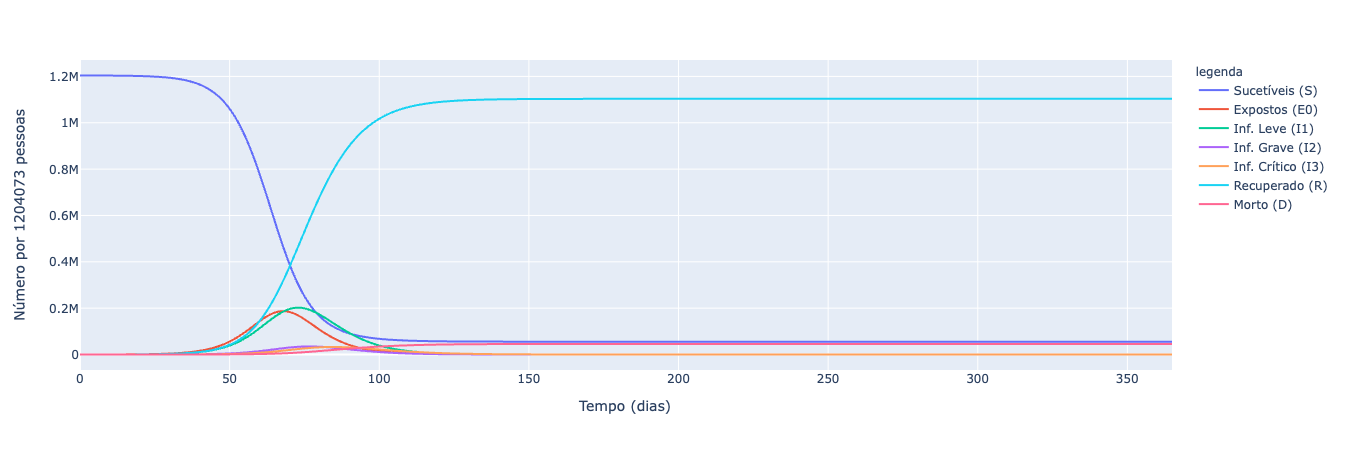

In [25]:

df = progression(IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N, tmax)

def covid19_1(yscale):
    if yscale == 'Log':
        fig = px.line(df, x="Tempo (dias)", y=y_index, color='legenda', log_y=True)
    else:
        fig = px.line(df, x="Tempo (dias)", y=y_index, color='legenda')
    return fig.show()
    
covid19_1(yscale)

% de infecções leves = 73.0%
Taxa de mortalidade geral = 4.0%


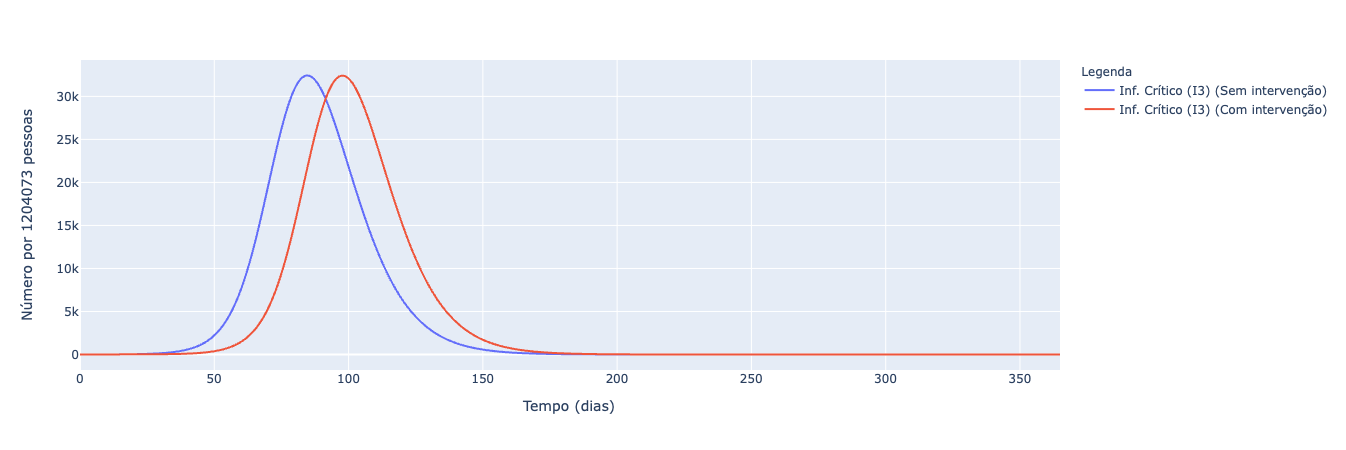

Sem intervenção: A taxa de crescimento epidêmico é 0.14 por dia; o tempo de duplicação é  5.1 dias
Com intervenção: A taxa de crescimento epidêmico é 0.00 por dia; o tempo de duplicação é  inf dias


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:191: RuntimeWarning:

divide by zero encountered in double_scalars



,Sem intervenção,Com intervenção
R₀,3.228000,0.468
r (por dia),0.136868,0.000
t₂,5.064332,inf


In [23]:
variable = 'Inf. Crítico (I3)'

df = interventionCases(variable, TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym, tmax, IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N)
        
#Plot
if yscale == 'Log':
    fig = px.line(df, x="Tempo (dias)", y=y_index, log_y=True, color = 'Legenda')
                
else:
    fig = px.line(df, x="Tempo (dias)", y=y_index, color = 'Legenda')
fig.show()
        
#Cálculo da taxa reprodutiva e etc    
if AllowSeason:
    R0 = taxa_reprodutiva_seas(N, be, b0, b1, b2, b3, p1, p2, g0, g1, g2, g3, a1, u, f, SeasAmp, SeasPhase)[0]
    R0Int = taxa_reprodutiva_seas(N, beInt, b0Int, b1Int, b2Int, b3Int, p1, p2, g0, g1, g2, g3, a1, u, f, SeasAmp, SeasPhase)[0]
else:
    R0 = taxa_reprodutiva(N, be, b0, b1, b2, b3, p1, p2, g0, g1, g2, g3, a1, u, f)
    R0 = taxa_reprodutiva(N, beInt, b0Int, b1Int, b2Int, b3Int, p1, p2, g0, g1, g2, g3, a1, u, f)

            
(r,DoublingTime) = new_growth_rate(g0,g1,g2,g3,p1,p2,be,b0,b1,b2,b3,u,a0,a1,N,f)
(rInt,DoublingTimeInt) = new_growth_rate(g0,g1,g2,g3,p1,p2,beInt,b0Int,b1Int,b2Int,b3Int,u,a0,a1,N,f)
        
Stat = pd.DataFrame({'Sem intervenção':[R0,r,DoublingTime],'Com intervenção':[R0Int,rInt,DoublingTimeInt]}, index=['R\N{SUBSCRIPT ZERO}','r (por dia)','t\N{SUBSCRIPT TWO}'])
print("Sem intervenção: A taxa de crescimento epidêmico é {0:4.2f} por dia; o tempo de duplicação é {1:4.1f} dias".format(r,DoublingTime))
print("Com intervenção: A taxa de crescimento epidêmico é {0:4.2f} por dia; o tempo de duplicação é {1:4.1f} dias".format(rInt,DoublingTimeInt))
Stat

% de infecções leves = 73.0%
Taxa de mortalidade geral = 4.0%


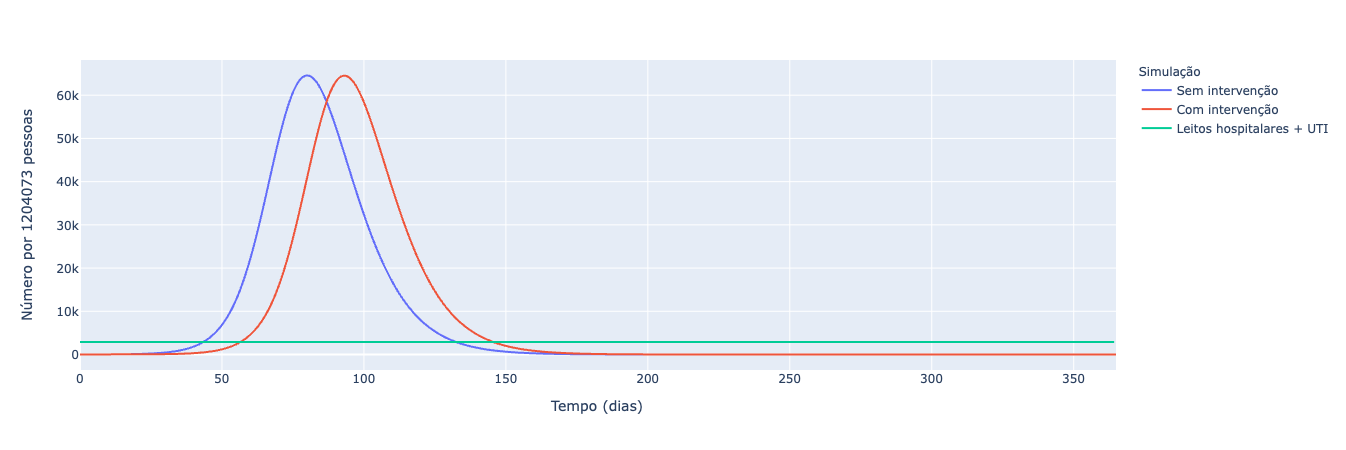

In [15]:
variable = 'Casos graves (I2) e críticos (I3) vs Leitos de hospital + UTI'

df = capacidade(variable,TimeStart,TimeEnd,reduc1,reduc2,reduc3,reducpre,reducasym, tmax,IncubPeriod, DurMildInf, FracSevere, FracCritical, ProbDeath, DurHosp, TimeICUDeath, AllowSeason, SeasAmp, SeasPhase, AllowAsym, FracAsym, DurAsym, AllowPresym, PresymPeriod, i, N)

fig = px.line(df, x="Tempo (dias)", y=y_index, color = 'Simulação')
fig.show()

In [20]:
print(variable,"será ultrapassada em",int(round(df[(df['Simulação']=='Sem intervenção') & (df[y_index]>=list(df[(df['Simulação']!='Sem intervenção') & (df['Simulação']!='Com intervenção')][y_index])[0])]['Tempo (dias)'].iloc[0],0)),"dias Sem Intevenção")
print(variable,"será ultrapassada em",int(round(df[(df['Simulação']=='Com intervenção') & (df[y_index]>=list(df[(df['Simulação']!='Sem intervenção') & (df['Simulação']!='Com intervenção')][y_index])[0])]['Tempo (dias)'].iloc[0],0)),"dias Com Intevenção")


Casos graves (I2) e críticos (I3) vs Leitos de hospital + UTI será ultrapassada em 44 dias Sem Intevenção
Casos graves (I2) e críticos (I3) vs Leitos de hospital + UTI será ultrapassada em 57 dias Com Intevenção


In [ ]:
#variable = "Expostos (E0)"
df1 = pd.DataFrame()
df2 = pd.DataFrame()
data_7 = pd.DataFrame()
data_30 = pd.DataFrame()

#Parâmetros do SEIR
a0, a1, u, g0, g1, g2, g3, p1, p2, f, ic = params(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)

#Calculo das taxas de transmissão durante a intervenção
b1Int = (1 - reduc1)*b1
b2Int = (1 - reduc2)*b2
b3Int = (1 - reduc3)*b3
beInt = (1 - reducpre)*be
b0Int = (1 - reducasym)*b0

tvec=np.arange(0,tmax,0.1)
soln=odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
        
names = ["Sucetíveis (S)","Expostos (E0)","Pré-sintomáticos (E1)","Assintomáticos (I0)","Inf. Leve (I1)","Inf. Grave (I2)","Inf. Crítico (I3)","Recuperado (R)","Morto (D)"]
#########  Simulação sem intervenção #########################################################
tvec=np.arange(0,tmax,0.1)
sim_sem_int = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
#Criando dataframe
df_sim_sem_int = pd.DataFrame(sim_sem_int, columns = names)
df_sim_sem_int['Tempo (dias)'] = tvec
df_sim_sem_int['Simulação'] = 'Sem intervenção'
#############################################################################################
        
#Simulação com intervenção
df_sim_com_int = simulacao(TimeStart, TimeEnd, tmax, i, N, a0, a1, b0, be, b1, b2 , b3, b0Int, beInt, b1Int, b2Int, b3Int, g0, g1, g2, g3, p1, p2, u, names, f, AllowAsym, AllowPresym, SeasAmp, SeasPhase)
y_index = 'Número por ' + str(N) +' pessoas'
df_sim_com_int = df_sim_com_int.drop_duplicates(subset = ['Tempo (dias)'], keep = 'first')
for variable in names:
    df_sem = pd.melt(df_sim_sem_int[['Tempo (dias)',variable]], id_vars = ['Tempo (dias)'], value_name = y_index, var_name = 'Legenda')
    df_sem['Legenda'] = df_sem['Legenda'] + ' (Sem intervenção)'
    df1 = df1.append(df_sem)
    df_com = pd.melt(df_sim_com_int[['Tempo (dias)',variable]], id_vars = ['Tempo (dias)'], value_name = y_index, var_name = 'Legenda')
    data_7 = data_7.append(df_com[(df_com['Tempo (dias)']==d_7)])
    data_30 = data_30.append(df_com[(df_com['Tempo (dias)']==d_30)])
    df_com['Legenda'] = df_com['Legenda'] + ' (Com intervenção)'
    df2 = df2.append(df_com)

#Junta dataframes
# df = df_sem.append(df_com)
df = df1.append(df2)
        
if AllowAsym == 'Não':
    df = df[(df['Legenda'] != "Assintomáticos (I0) (Sem intervenção)") & (df['Legenda'] != "Assintomáticos (I0) (Com intervenção)")]
if AllowPresym == 'Não':
    df = df[(df['Legenda'] != "Pré-sintomáticos (E1) (Sem intervenção)") & (df['Legenda'] != "Pré-sintomáticos (E1) (Com intervenção)")]
        
#Plot
if yscale == 'Log':
    fig = px.line(df, x="Tempo (dias)", y=y_index, log_y=True, color = 'Legenda')
                
else:
    fig = px.line(df, x="Tempo (dias)", y=y_index, color = 'Legenda')
fig.show()
        
#Cálculo da taxa reprodutiva e etc    
if AllowSeason:
    R0 = taxa_reprodutiva_seas(N, be, b0, b1, b2, b3, p1, p2, g0, g1, g2, g3, a1, u, f, SeasAmp, SeasPhase)[0]
    R0Int = taxa_reprodutiva_seas(N, beInt, b0Int, b1Int, b2Int, b3Int, p1, p2, g0, g1, g2, g3, a1, u, f, SeasAmp, SeasPhase)[0]
else:
    R0 = taxa_reprodutiva(N, be, b0, b1, b2, b3, p1, p2, g0, g1, g2, g3, a1, u, f)
    R0 = taxa_reprodutiva(N, beInt, b0Int, b1Int, b2Int, b3Int, p1, p2, g0, g1, g2, g3, a1, u, f)

            
(r,DoublingTime) = new_growth_rate(g0,g1,g2,g3,p1,p2,be,b0,b1,b2,b3,u,a0,a1,N,f)
(rInt,DoublingTimeInt) = new_growth_rate(g0,g1,g2,g3,p1,p2,beInt,b0Int,b1Int,b2Int,b3Int,u,a0,a1,N,f)

def casosPorTipo(list0,list1):
    count = 0
    total = sum(list1)
    for i in list1:
        n = int(round(i/total*1600,1))
        if count == 1 or count == 3:
            n1 = n
        elif count == 2 or count == 4:
            n = n+n1
            list0.append(n)
        else:
            list0.append(n)
        count+=1 
    return list0

day7 = casosPorTipo([],list(data_7[y_index]))
day30 = casosPorTipo([],list(data_30[y_index]))

Stat = pd.DataFrame({'Sem intervenção':[R0,r,DoublingTime],'Com intervenção':[R0Int,rInt,DoublingTimeInt]}, index=['R\N{SUBSCRIPT ZERO}','r (por dia)','t\N{SUBSCRIPT TWO}'])

print("Sem intervenção: A taxa de crescimento epidêmico é {0:4.2f} por dia; o tempo de duplicação é {1:4.1f} dias".format(r,DoublingTime))
print("Com intervenção: A taxa de crescimento epidêmico é {0:4.2f} por dia; o tempo de duplicação é {1:4.1f} dias".format(rInt,DoublingTimeInt))
print(Stat)



In [ ]:
names1 = ["Sucetíveis (S)","Expostos (E0)","Pré-sintomáticos (E1)","Assintomáticos (I0)","Inf. Leve (I1)","Inf. Grave (I2)","Inf. Crítico (I3)","Recuperado (R)","Morto (D)"]
if AllowAsym == 'Não':
    names1.remove("Assintomáticos (I0)")
if AllowPresym == 'Não':
    names1.remove("Pré-sintomáticos (E1)")

print("Previsão em 7 dias")

df = df[(df['Legenda']!='Sucetíveis (S) (Sem intervenção)')]
df = df[(df['Legenda']!='Expostos (E0) (Sem intervenção)')]
df = df[(df['Legenda']!='Inf. Leve (I1) (Sem intervenção)')]
df = df[(df['Legenda']!='Inf. Grave (I2) (Sem intervenção)')]
df = df[(df['Legenda']!='Inf. Crítico (I3) (Sem intervenção)')]
df = df[(df['Legenda']!='Recuperado (R) (Sem intervenção)')]
df = df[(df['Legenda']!='Morto (D) (Sem intervenção)')]

if AllowAsym == 'Sim':
    df = df[(df['Legenda']!='Assintomáticos (I0) (Som intervenção)')]
if AllowPresym == 'Sim':
    df = df[(df['Legenda']!='Pré-sintomáticos (E1) (Com intervenção)')]
    
fig = px.treemap(df[(df['Tempo (dias)']==d_7)], path=['Legenda'], values=y_index,
                  color='Legenda', hover_data=[y_index],
                  color_continuous_scale='RdBu')
fig.show()

fig = plt.figure(
    figsize=[10.1, 10.1],
    facecolor=(0,0,0,1),
    FigureClass=Waffle,
    rows=40,
    columns=40,
    values=day7,
    colors=["#FFFFFF", "#FF00FF", "#FFFF00", "#FF9900", "#FF0000", "#00FF00", "#9900FF"],
    icons='user',
    icon_size=12,
    icon_style='solid',
    icon_legend=False,
    legend={
        'labels': names1, 
        'loc': 'upper left', 
        'bbox_to_anchor': (1, 1)
    }
)
fig.patch.set_visible(False)


In [ ]:
print("Previsão em 30 dias")

fig = px.treemap(df[(df['Tempo (dias)']==d_30)], path=['Legenda'], values=y_index,
                  color='Legenda', hover_data=[y_index],
                  color_continuous_scale='RdBu')
fig.show()

fig_com = plt.figure(
    figsize=[10.1, 10.1],
    facecolor=(0,0,0,1),
    FigureClass=Waffle,
    rows=40,
    columns=40,
    values=day30,
    colors=["#FFFFFF", "#FF00FF", "#FFFF00", "#FF9900", "#FF0000", "#00FF00", "#9900FF"],
    icons='user',
    icon_size=12,
    icon_style='solid',
    icon_legend=False,
    legend={
        'labels': names1, 
        'loc': 'upper left', 
        'bbox_to_anchor': (1, 1)
    }
)
fig_com.patch.set_visible(False)


In [ ]:
casos = ['Casos graves (I2) e críticos (I3) vs Leitos de hospital + UTI']
       
a0, a1, u, g0, g1, g2, g3, p1, p2, f, ic = params(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)

b1Int = (1 - reduc1)*b1
b2Int = (1 - reduc2)*b2
b3Int = (1 - reduc3)*b3
beInt = max(0,(1 - reducpre)*be)
b0Int = max(0,(1 - reducasym)*b0) 
        
names = ["Sucetíveis (S)","Expostos (E1)","Pré-sintomáticos (E1)","Assintomáticos (I0)","Inf. Leve (I1)","Inf. Grave (I2)","Inf. Crítico (I3)","Recuperado (R)","Morto (D)"]

#########  Simulação sem intervenção #########################################################
tvec=np.arange(0,tmax,0.1)
sim_sem_int = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
#Criando dataframe
df_sim_sem_int = pd.DataFrame(sim_sem_int, columns = names)
df_sim_sem_int['Tempo (dias)'] = tvec
df_sim_sem_int['Simulação'] = 'Sem intervenção'
#############################################################################################

df_sim_sem_int = withoutIntervent(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)
    
df_sim_com_int = withIntevent(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)
    
#Simulação com intervenção
df_sim_com_int = simulacao(TimeStart, TimeEnd, tmax, i, N, a0, a1, b0, be, b1, b2 , b3, b0Int, beInt, b1Int, b2Int, b3Int, g0, g1, g2, g3, p1, p2, u, names, f, AllowAsym, AllowPresym, SeasAmp, SeasPhase)
y_index = 'Número por ' + str(N) +' pessoas'  

#df_sim_sem_int = withoutIntervent(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)
    
#df_sim_com_int = withIntevent(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)

for variable in casos:
    #Plots
    if variable == 'Todos casos sintomáticos (I1,I2,I3) vs Leitos de hospital + UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Leve (I1)"] + df_sim_com_int["Inf. Grave (I2)"] + df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Leve (I1)"] + df_sim_sem_int["Inf. Grave (I2)"] + df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])

        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos hospitalares + UTI',AvailHospBeds + AvailICUBeds])
                
        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))
            
    elif variable == 'Casos graves (I2) e críticos (I3) vs Leitos de hospital + UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Grave (I2)"] + df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Grave (I2)"] + df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])
            
        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos hospitalares + UTI',AvailHospBeds + AvailICUBeds])
                
        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))

    elif variable == 'Infecções críticas (I3) vs Leitos na UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])
            
        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos da UTI',AvailICUBeds])
                
        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))
        
    elif variable == 'Infecções críticas (I3) vs Capacidade de ventilação':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])
            
        data1 = []
        data2 = []
        data3 = []
        for x in range(0, tmax):
            data1.append([x,'Ventilação em protocolos convencionais',ConvVentCap])
            data2.append([x,'Ventilação em protocolo de convenção',ContVentCap])
            data3.append([x,'Ventilação em protocolo de crise',CrisisVentCap])
                
        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))
        df = df.append(pd.DataFrame(data2, columns = ['Tempo (dias)','Simulação',y_index]))
        df = df.append(pd.DataFrame(data3, columns = ['Tempo (dias)','Simulação',y_index]))
            
    fig = px.line(df, x="Tempo (dias)", y=y_index, color='Simulação')
    fig.show()
    print(variable,"será ultrapassada em",int(round(df[(df['Simulação']=='Sem intervenção') & (df[y_index]>=data1[0][2])]['Tempo (dias)'].iloc[0],0)),"dias Sem Intevenção")
    print(variable,"será ultrapassada em",int(round(df[(df['Simulação']=='Com intervenção') & (df[y_index]>=data1[0][2])]['Tempo (dias)'].iloc[0],0)),"dias Com Intevenção")


In [ ]:
casos = ['Infecções críticas (I3) vs Leitos na UTI']
       
a0, a1, u, g0, g1, g2, g3, p1, p2, f, ic = params(IncubPeriod, FracMild, FracCritical, FracSevere, TimeICUDeath, CFR, DurMildInf, DurHosp, i, PresymPeriod, FracAsym, DurAsym, N)

b1Int = (1 - reduc1)*b1
b2Int = (1 - reduc2)*b2
b3Int = (1 - reduc3)*b3
beInt = max(0,(1 - reducpre)*be)
b0Int = max(0,(1 - reducasym)*b0) 
        
names = ["Sucetíveis (S)","Expostos (E1)","Pré-sintomáticos (E1)","Assintomáticos (I0)","Inf. Leve (I1)","Inf. Grave (I2)","Inf. Crítico (I3)","Recuperado (R)","Morto (D)"]

#########  Simulação sem intervenção #########################################################
tvec=np.arange(0,tmax,0.1)
sim_sem_int = odeint(seir,ic,tvec,args=(a0,a1,g0,g1,g2,g3,p1,p2,u,be,b0,b1,b2,b3,f, AllowPresym, AllowAsym, SeasAmp, SeasPhase))
#Criando dataframe
df_sim_sem_int = pd.DataFrame(sim_sem_int, columns = names)
df_sim_sem_int['Tempo (dias)'] = tvec
df_sim_sem_int['Simulação'] = 'Sem intervenção'
#############################################################################################
        
#Simulação com intervenção
df_sim_com_int = simulacao(TimeStart, TimeEnd, tmax, i, N, a0, a1, b0, be, b1, b2 , b3, b0Int, beInt, b1Int, b2Int, b3Int, g0, g1, g2, g3, p1, p2, u, names, f, AllowAsym, AllowPresym, SeasAmp, SeasPhase)
y_index = 'Número por ' + str(N) +' pessoas'  

for variable in casos:
    #Plots
    if variable == 'Todos casos sintomáticos (I1,I2,I3) vs Leitos de hospital + UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Leve (I1)"] + df_sim_com_int["Inf. Grave (I2)"] + df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Leve (I1)"] + df_sim_sem_int["Inf. Grave (I2)"] + df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])

        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos hospitalares + UTI',AvailHospBeds + AvailICUBeds])
                
        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))
            
    elif variable == 'Casos graves (I2) e críticos (I3) vs Leitos de hospital + UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Grave (I2)"] + df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Grave (I2)"] + df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])
            
        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos hospitalares + UTI',AvailHospBeds + AvailICUBeds])
                
        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))

    elif variable == 'Infecções críticas (I3) vs Leitos na UTI':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])
            
        data1 = []
        for x in range(0, tmax):
            data1.append([x,'Leitos da UTI',AvailICUBeds])
                
        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))
        
    elif variable == 'Infecções críticas (I3) vs Capacidade de ventilação':
        df_sim_com_int[y_index] = df_sim_com_int["Inf. Crítico (I3)"]
        df_sim_sem_int[y_index] = df_sim_sem_int["Inf. Crítico (I3)"]
        df = df_sim_sem_int[['Tempo (dias)',y_index, 'Simulação']].append(df_sim_com_int[['Tempo (dias)',y_index, 'Simulação']])
            
        data1 = []
        data2 = []
        data3 = []
        for x in range(0, tmax):
            data1.append([x,'Ventilação em protocolos convencionais',ConvVentCap])
            data2.append([x,'Ventilação em protocolo de convenção',ContVentCap])
            data3.append([x,'Ventilação em protocolo de crise',CrisisVentCap])
                
        df = df.append(pd.DataFrame(data1, columns = ['Tempo (dias)','Simulação',y_index]))
        df = df.append(pd.DataFrame(data2, columns = ['Tempo (dias)','Simulação',y_index]))
        df = df.append(pd.DataFrame(data3, columns = ['Tempo (dias)','Simulação',y_index]))
            
    fig = px.line(df, x="Tempo (dias)", y=y_index, color='Simulação')
    fig.show()
    
#     print(variable,"será ultrapassada em",int(round(df[(df['Simulação']=='Sem intervenção') & (df[y_index]>=data1[0][2])]['Tempo (dias)'].iloc[0],0)),"dias Sem Intevenção")
#     print(variable,"será ultrapassada em",int(round(df[(df['Simulação']=='Com intervenção') & (df[y_index]>=data1[0][2])]['Tempo (dias)'].iloc[0],0)),"dias Com Intevenção")

df[(df['Simulação']=='Com intervenção')].head(50)

In [ ]:
def Scale(list):
    list1=[]
    for n in list:
        n = (n/sum(list))*1600
        list1.append(n)
    return list1
end = [6635,1,4,1,39,1137561,59831]
end = Scale(end)
v = [1203633,186,121,10,3,121,2]
v = Scale(v)
names1 = ['Suscetível (S)','Exposto (E0)','Infec. Leve (I1)','Infec. Grave (I2)','Infec. Crítica (I3)','Recuperado (R)','Morto (D)']
Tempo = [7,7,7,7,7,7,7]
data = [[7,names1[0],v[0]],[7,names1[1],v[1]],[7,names1[2],v[2]],[7,names1[3],v[3]],[7,names1[4],v[4]],[7,names1[5],v[5]],[7,names1[6],v[6]]]
data = [[7,names1[0],end[0]],[7,names1[1],end[1]],[7,names1[2],end[2]],[7,names1[3],end[3]],[7,names1[4],end[4]],[7,names1[5],end[5]],[7,names1[6],end[6]]]
df = pd.DataFrame(data, columns=['Tempo (dias)', 'Legenda','Pessoas'])
fig = px.treemap(df, path=['Legenda'], values='Pessoas',
                  color='Legenda', hover_data=['Pessoas'],
                  color_continuous_scale='RdBu')
fig.show()

fig = plt.figure(
    figsize=[10.1, 10.1],
    facecolor=(0,0,0,1),
    FigureClass=Waffle,
    rows=40,
    columns=40,
    values=end,
    colors=["#FFFFFF", "#FF00FF", "#FFFF00", "#FF9900", "#FF0000", "#00FF00", "#9900FF"],
    icons='user',
    icon_size=12,
    icon_style='solid',
    icon_legend=False,
    legend={
        'labels': names1, 
        'loc': 'upper left', 
        'bbox_to_anchor': (1, 1)
    }
)
fig.patch.set_visible(False)
df

In [ ]:
fig = plt.figure(
    figsize=[100.1, 100.1],
    facecolor=(0,0,0,1),
    FigureClass=Waffle, 
    rows=10,
    columns=160,
    block_aspect_ratio=1,

    values=end, 
    colors=["#FFFFFF", "#FF00FF", "#FFFF00", "#FF9900", "#FF0000", "#00FF00", "#9900FF"],
    title={'label': 'Fim da Pândemia', 'loc': 'left'},
    #labels=names1,
    #legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0}
)
fig.patch.set_visible(False)
plt.show()

In [ ]:
def Scale(list):
    list1=[]
    for n in list:
        n = (n/sum(list))*1600
        list1.append(n)
    return list1
end = [6635,1,4,1,39,1137561,59831]
end = Scale(end)
v = [1203633,186,121,10,3,121,2]
v = Scale(v)
names1 = ['Suscetível (S)','Exposto (E0)','Infec. Leve (I1)','Infec. Grave (I2)','Infec. Crítica (I3)','Recuperado (R)','Morto (D)']
Tempo = [7,7,7,7,7,7,7]
fig = plt.figure(
    figsize=[100.1, 100.1],
    facecolor=(0,0,0,1),
    FigureClass=Waffle, 
    rows=10,
    columns=160,
    block_aspect_ratio=1,

    values=v, 
    colors=["#FFFFFF", "#FF00FF", "#FFFF00", "#FF9900", "#FF0000", "#00FF00", "#9900FF"],
    title={'label': 'Fim da Pândemia', 'loc': 'left'},
    #labels=names1,
    #legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0}
)
fig.patch.set_visible(False)
plt.show()

In [ ]:
def Scale(list):
    list1=[]
    for n in list:
        n = (n/sum(list))*5000
        list1.append(n)
    return list1
end = [6635,1,4,1,39,1137561,59831]
end = Scale(end)
v = [1203633,186,121,10,3,121,2]
v = Scale(v)
print(v)
print(end)
names1 = ['Suscetível (S)','Exposto (E0)','Infec. Leve (I1)','Infec. Grave (I2)','Infec. Crítica (I3)','Recuperado (R)','Morto (D)']
Tempo = [7,7,7,7,7,7,7]
fig = plt.figure(
    figsize=[100.1, 100.1],
    facecolor=(0,0,0,1),
    FigureClass=Waffle, 
    rows=20,
    columns=250,
    block_aspect_ratio=1,

    values=v, 
    colors=["#FFFFFF", "#FF00FF", "#FFFF00", "#FF9900", "#FF0000", "#00FF00", "#9900FF"],
    title={'label': 'Fim da Pândemia', 'loc': 'left'},
    #labels=names1,
    #legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0}
)
fig.patch.set_visible(False)
plt.show()

fig2 = plt.figure(
    figsize=[100.1, 100.1],
    facecolor=(0,0,0,1),
    FigureClass=Waffle, 
    rows=20,
    columns=250,
    block_aspect_ratio=1,

    values=end, 
    colors=["#FFFFFF", "#FF00FF", "#FFFF00", "#FF9900", "#FF0000", "#00FF00", "#9900FF"],
    title={'label': 'Fim da Pândemia', 'loc': 'left'},
    #labels=names1,
    #legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0}
)
fig2.patch.set_visible(False)
plt.show()